In [1]:
import logging
import warnings

import numpy as np
import scipy.stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=10000, num_features=2000)
sim.generate_sample_description(num_batches=0, num_confounders=0)
sim.generate()

random_sample_description = pd.DataFrame({
    "condition": np.random.randint(2, size=sim.num_observations),
    "batch": np.random.randint(4, size=sim.num_observations)
})

np.unique(random_sample_description, axis=0)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3]])

Run differential expression test:

In [3]:
logging.getLogger("tensorflow").setLevel(logging.WARNING)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

# just to ignore some tensorflow warnings; just ignore this line
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

import diffxpy.api as de

test = de.test.lrt(
    data=sim.X,
    full_formula="~ 1 + batch + condition",
    reduced_formula="~ 1",
    sample_description=random_sample_description,
    dtype="float64"
)


lrt is not ready for usage yet!
Estimating model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True
training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.01,
  'loss_window_size': 10,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.25,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready
Estimating model...
Using closed-form MLE initialization for mean
Should train mu: True
Using closed-form MME initialization for dispersion
Should train r: True
training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.1,
  'loss_window_size': 100,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': True},
 {'convergence_criteria': 't_test',
  'learning_rate': 0.05,
  'loss_window_size': 10,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': False}]
Beginning with 

In [4]:
full_model = test.full_estim
reduced_model = test.reduced_estim

ll_full = np.sum(full_model.log_probs(), axis=0)
ll_reduced = np.sum(reduced_model.log_probs(), axis=0)
delta_dev = 2 * (ll_full - ll_reduced)

delta_df = (full_model.design_loc.shape[-1] - reduced_model.design_loc.shape[-1]) + \
           (full_model.design_scale.shape[-1] - reduced_model.design_scale.shape[-1])

expected_dist = scipy.stats.chi2(delta_df)

print("failed features (should be empty):")
np.where(ll_full < ll_reduced)


failed features (should be empty):


(array([364]),)

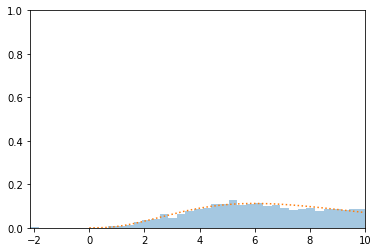

In [5]:
fig, ax = plt.subplots()
sns.distplot(delta_dev, norm_hist=True, kde=False, bins=100, ax=ax)

xmin = np.min(delta_dev)
xmax = 10.
ymax = 1.
ax.set_xlim(xmin, xmax)
ax.set_ylim(top=ymax)

x = np.arange(0, xmax, xmax / 2000)
ax.plot(x, expected_dist.pdf(x), label='chi²', linestyle=":")
# ax.set_xscale("log")

plt.show()
plt.close()

